In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
# import warnings
# warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("Post(Post).csv")

# Display dataset info
print("\nDataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)


Dataset Shape: (2952, 18)

Data Types:
Days for shipping (real)                                     float64
Days for shipment (scheduled)                                float64
Delivery Status                                               object
Customer Segment                                              object
Latitude                                                     float64
Longitude                                                    float64
Order City                                                    object
order date (DateOrders)                                       object
Order Item Id                                                float64
Order Item Quantity                                          float64
Order State                                                   object
Order Status                                                  object
shipping date (DateOrders)                                    object
Shipping Mode                                                 o

In [4]:
time_slots = [
    '10:00 AM - 12:00 PM',
    '12:00 PM - 03:00 PM',
    '03:00 PM - 05:00 PM'
]

df['shipping_delay'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']

user_id_mapping = df.groupby('User ID')['Machine Prediction'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
df['user_id_encoded'] = df['User ID'].map(user_id_mapping)

numeric_features = [
    'Days for shipping (real)',
    'Days for shipment (scheduled)',
    'Order Item Quantity',
    'shipping_delay'
]

categorical_features = [
    'Delivery Status',
    'Customer Segment',
    'Shipping Mode',
    'user_id_encoded'
]

ordinal_features = [
    'Admin Recomended Slots/Previous Optimized Delivered Slots',
    'Parcel Delivered in This Slot'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[time_slots] * len(ordinal_features)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='drop'
)

y = df['Machine Prediction']
y_encoder = OrdinalEncoder(categories=[time_slots])
y_encoded = y_encoder.fit_transform(y.values.reshape(-1, 1)).ravel()

models = {
    'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_features="log2", random_state=42),
    'XGBoost': xgb.XGBClassifier(
            objective='multi:softprob',
            learning_rate=0.01,
            max_depth=1,
            n_estimators=100,
            random_state=42,
            eval_metric='mlogloss'
        )
}

pipelines = {name: Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
]) for name, model in models.items()}

In [5]:
def evaluate_models(X, y, pipelines):
    results = {}

    n_classes = len(np.unique(y))
    is_multiclass = n_classes > 2

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nEvaluating models with 80-20 split:")
    test_predictions = {}
    test_probabilities = {}

    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        test_predictions[name] = y_pred

        if hasattr(pipeline, "predict_proba"):
            y_prob = pipeline.predict_proba(X_test)
            test_probabilities[name] = y_prob

        accuracy = accuracy_score(y_test, y_pred)
        results[f"{name}_simple_split"] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")

        if name == 'XGBoost':
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # print("\nConfusion Matrix:")
            # cm = confusion_matrix(y_test, y_pred)
            # print(cm)

    # if is_multiclass:
    #     plt.figure(figsize=(12, 10))
    #     for name, y_probs in test_probabilities.items():
    #         from sklearn.metrics import roc_auc_score
    #         roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr', average='macro')

    #         for i in range(n_classes):
    #             fpr, tpr, _ = roc_curve(
    #                 (y_test == i).astype(int),
    #                 y_probs[:, i]
    #             )
    #             plt.plot(
    #                 fpr, tpr, lw=1.5,
    #                 label=f'{name}, Class {i} (AUC = {auc(fpr, tpr):.4f})'
    #             )

    #         print(f"{name} Macro-averaged ROC AUC: {roc_auc:.4f}")

    #     plt.plot([0, 1], [0, 1], 'k--', lw=2)
    #     plt.xlim([0.0, 1.0])
    #     plt.ylim([0.0, 1.05])
    #     plt.xlabel('False Positive Rate')
    #     plt.ylabel('True Positive Rate')
    #     plt.title('ROC Curves (One-vs-Rest)')
    #     plt.legend(loc="lower right")
    #     plt.grid(True)
    #     plt.show()

    print("\nEvaluating models with 5-fold CV:")
    cv_results = {}
    for name, pipeline in pipelines.items():
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
        cv_results[name] = cv_scores
        results[f"{name}_5fold_cv"] = cv_scores.mean()
        print(f"{name} CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    print("\nEvaluating models with 10-fold CV:")
    cv_results_10 = {}
    for name, pipeline in pipelines.items():
        cv_scores = cross_val_score(pipeline, X, y, cv=10, scoring='accuracy')
        cv_results_10[name] = cv_scores
        results[f"{name}_10fold_cv"] = cv_scores.mean()
        print(f"{name} CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    best_model = max(results.items(), key=lambda x: x[1])
    print(f"\nBest Model: {best_model[0]} with accuracy {best_model[1]:.4f}")

    return results, cv_results, cv_results_10, X_test, y_test, test_predictions, test_probabilities


Evaluating models with 80-20 split:
Logistic Regression Accuracy: 1.0000
K-Nearest Neighbors Accuracy: 0.8426
Random Forest Accuracy: 1.0000
XGBoost Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      1.00      1.00        88
         2.0       1.00      1.00      1.00        45

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197


Evaluating models with 5-fold CV:
Logistic Regression CV Accuracy: 1.0000 (±0.0000)
K-Nearest Neighbors CV Accuracy: 0.8689 (±0.0292)
Random Forest CV Accuracy: 0.9949 (±0.0079)
XGBoost CV Accuracy: 1.0000 (±0.0000)

Evaluating models with 10-fold CV:
Logistic Regression CV Accuracy: 1.0000 (±0.0000)
K-Nearest Neighbors CV Accuracy: 0.8822 (±0.0521)
Random Forest CV Accuracy: 0.9970 (±0.0065)
XGBoost CV Accuracy: 1.0000 (±0

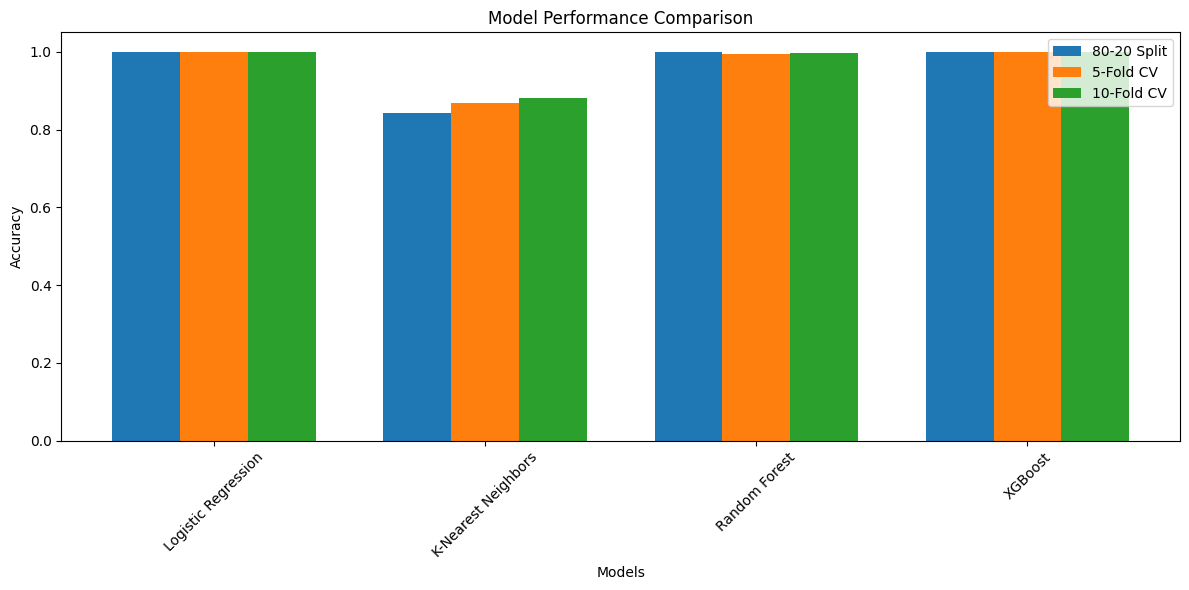

In [6]:
X = df.drop(['Machine Prediction'], axis=1)
results, cv_results, cv_results_10, X_test, y_test, test_predictions, test_probabilities = evaluate_models(X, y_encoded, pipelines)

# Visualize model performance
model_names = list(models.keys())
simple_split_scores = [results[f"{name}_simple_split"] for name in model_names]
cv5_scores = [results[f"{name}_5fold_cv"] for name in model_names]
cv10_scores = [results[f"{name}_10fold_cv"] for name in model_names]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, simple_split_scores, width, label='80-20 Split')
plt.bar(x, cv5_scores, width, label='5-Fold CV')
plt.bar(x + width, cv10_scores, width, label='10-Fold CV')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Visualize feature importance for the best model (if applicable)
best_model_name = max(results.items(), key=lambda x: x[1])[0].split('_')[0]
if best_model_name in ['Random Forest', 'XGBoost']:
    best_pipeline = pipelines[best_model_name]
    best_pipeline.fit(X, y_encoded)

    feature_names = []

    numeric_idx = preprocessor.transformers_[0][2]
    feature_names.extend([numeric_features[i] for i in numeric_idx])

    categorical_idx = preprocessor.transformers_[1][2]
    cat_features = []
    for i, cat_feature in enumerate(categorical_idx):
        if cat_feature < len(categorical_features):
            cat_values = df[categorical_features[cat_feature]].dropna().unique()
            cat_features.extend([f"{categorical_features[cat_feature]}_{val}" for val in cat_values])
    feature_names.extend(cat_features)

    ordinal_idx = preprocessor.transformers_[2][2]
    feature_names.extend([ordinal_features[i] for i in ordinal_idx])

    try:
        if best_model_name == 'Random Forest':
            importances = best_pipeline.named_steps['classifier'].feature_importances_
        else:  # XGBoost
            importances = best_pipeline.named_steps['classifier'].feature_importances_

        if len(feature_names) > len(importances):
            feature_names = feature_names[:len(importances)]
        elif len(feature_names) < len(importances):
            feature_names.extend([f"Feature_{i}" for i in range(len(feature_names), len(importances))])

        plt.figure(figsize=(12, 8))
        sorted_idx = np.argsort(importances)[::-1]
        top_features = min(20, len(sorted_idx))

        plt.barh(range(top_features), importances[sorted_idx[:top_features]])
        plt.yticks(range(top_features), [feature_names[i] if i < len(feature_names) else f"Feature {i}"
                                         for i in sorted_idx[:top_features]])
        plt.title(f'Top Feature Importances - {best_model_name}')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error visualizing feature importances: {e}")
        print("Continuing with model evaluation...")


Prediction Example:
For a new order with:
  - Customer Segment: Consumer
  - Shipping Mode: Standard Class
  - Admin Recommended Slot: 10:00 AM - 12:00 PM
  - Parcel Delivered Slot: 12:00 PM - 03:00 PM
The model predicts the optimal delivery slot to be: 10:00 AM - 12:00 PM

User Preference Analysis:
Machine Prediction  03:00 PM - 05:00 PM  10:00 AM - 12:00 PM  \
User ID                                                        
24                                  0.0                  2.0   
33                                  1.0                  1.0   
39                                  2.0                  1.0   
40                                  5.0                  1.0   
43                                  2.0                  1.0   

Machine Prediction  12:00 PM - 03:00 PM  
User ID                                  
24                                  1.0  
33                                  0.0  
39                                  1.0  
40                                  1.0

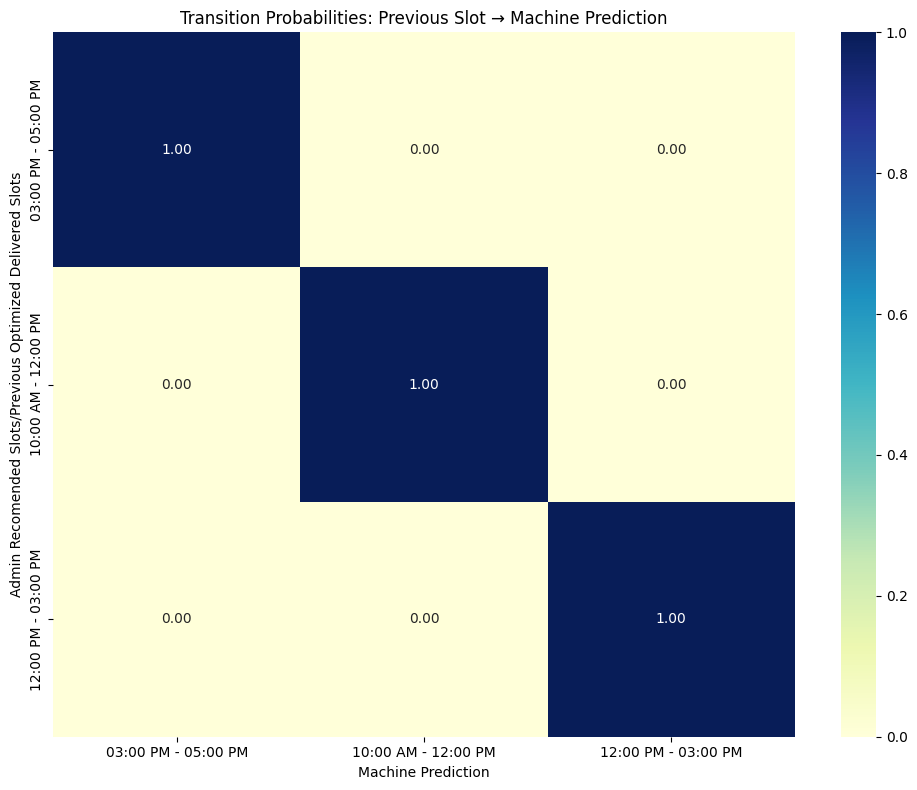


Delivery Slot Prediction Model Complete

Saving models to pickle files...
Saved Logistic Regression pipeline to saved_models/logistic_regression_pipeline.pkl
Saved K-Nearest Neighbors pipeline to saved_models/k-nearest_neighbors_pipeline.pkl
Saved Random Forest pipeline to saved_models/random_forest_pipeline.pkl
Saved XGBoost pipeline to saved_models/xgboost_pipeline.pkl
Saved best model (Logistic Regression) to saved_models/best_model_logistic_regression.pkl
Saved encoders and preprocessing components to saved_models/encoders.pkl


In [7]:
# Create a function for making predictions
def predict_delivery_slot(data, pipeline, y_encoder):
    if isinstance(data, dict):
        data = pd.DataFrame([data])

    pred_encoded = pipeline.predict(data)

    pred_decoded = y_encoder.inverse_transform(pred_encoded.reshape(-1, 1))

    return pred_decoded[0][0]

new_order = {
    'Days for shipping (real)': 4,
    'Days for shipment (scheduled)': 3,
    'Delivery Status': 'Advance shipping',
    'Customer Segment': 'Consumer',
    'Order Item Quantity': 2,
    'Shipping Mode': 'Standard Class',
    'User ID': 45,
    'Admin Recomended Slots/Previous Optimized Delivered Slots': '10:00 AM - 12:00 PM',
    'Parcel Delivered in This Slot': '12:00 PM - 03:00 PM'
}

new_order['shipping_delay'] = new_order['Days for shipping (real)'] - new_order['Days for shipment (scheduled)']
new_order['user_id_encoded'] = user_id_mapping.get(new_order['User ID'])

best_pipeline = pipelines[best_model_name]
predicted_slot = predict_delivery_slot(new_order, best_pipeline, y_encoder)

print("\nPrediction Example:")
print(f"For a new order with:")
print(f"  - Customer Segment: {new_order['Customer Segment']}")
print(f"  - Shipping Mode: {new_order['Shipping Mode']}")
print(f"  - Admin Recommended Slot: {new_order['Admin Recomended Slots/Previous Optimized Delivered Slots']}")
print(f"  - Parcel Delivered Slot: {new_order['Parcel Delivered in This Slot']}")
print(f"The model predicts the optimal delivery slot to be: {predicted_slot}")

print("\nUser Preference Analysis:")
user_slot_preferences = df.groupby('User ID')['Machine Prediction'].value_counts().unstack().fillna(0)
print(user_slot_preferences.head())

# Analyze how often users get their preferred slots
user_preferred_slots = df.groupby('User ID')['Machine Prediction'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df['preferred_slot'] = df['User ID'].map(user_preferred_slots)
df['got_preferred_slot'] = df['Machine Prediction'] == df['preferred_slot']

print("\nPercentage of users getting their preferred slots:")
print(df['got_preferred_slot'].mean() * 100, "%")

# Analyze the impact of previous slots on the machine prediction
print("\nImpact of Previous Slots on Machine Prediction:")
slot_transition = pd.crosstab(
    df['Admin Recomended Slots/Previous Optimized Delivered Slots'],
    df['Machine Prediction']
)
print(slot_transition)

# Normalize to see probabilities
slot_transition_norm = slot_transition.div(slot_transition.sum(axis=1), axis=0)
print("\nNormalized Slot Transition Probabilities:")
print(slot_transition_norm)

# Visualize the transition probabilities
plt.figure(figsize=(10, 8))
sns.heatmap(slot_transition_norm, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Transition Probabilities: Previous Slot → Machine Prediction')
plt.tight_layout()
plt.show()

print("\nDelivery Slot Prediction Model Complete")

# Save all models to pickle files
print("\nSaving models to pickle files...")
import pickle
import os

# Create a directory for the models if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save each model pipeline
for name, pipeline in pipelines.items():
    model_filename = f'saved_models/{name.replace(" ", "_").lower()}_pipeline.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(pipeline, file)
    print(f"Saved {name} pipeline to {model_filename}")

# Save the best model separately
best_model_filename = f'saved_models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl'
with open(best_model_filename, 'wb') as file:
    pickle.dump(pipelines[best_model_name], file)
print(f"Saved best model ({best_model_name}) to {best_model_filename}")

# Save the encoders and transformers
encoders_filename = 'saved_models/encoders.pkl'
encoders_dict = {
    'y_encoder': y_encoder,
    'preprocessor': preprocessor,
    'time_slots': time_slots
}
with open(encoders_filename, 'wb') as file:
    pickle.dump(encoders_dict, file)
print(f"Saved encoders and preprocessing components to {encoders_filename}")